In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # module for plotting 
import seaborn as sns
import sys
import os
import glob
import cPickle as pickle
import re
import csv
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [2]:
# check if there is preprocessed dataset

In [3]:
# if not load raw dataset

In [4]:
def progress_update(curr_counts,update_counts,total_counts):
    if update_counts == 0:
        print "%d percent has been processed...\r" %((curr_counts+1)*100/total_counts),
    else:
        if (curr_counts+1)%update_counts == 0:
            print "%d percent has been processed...\r" %((curr_counts+1)/update_counts),

In [5]:
def doc2wordlist(doc,remove_html=False,stop_words=False,stem_words=False ):    
    # Function to convert a document to a sequence of words,
    # Returns a list of words.
    #
    # 1. Optionally remove HTML
    if remove_html:
        doc = BeautifulSoup(doc).get_text()
    #  
    # 2. Remove non-letters
    text = re.sub("[^a-zA-Z]"," ", doc)
    #
    # 3. Convert words to lower case and split them
    words = text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if stop_words:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Optionally remove stem words (false by default)
    if stem_words:
        words = [stemmer.stem(w) for w in words]
    # Return list of words    
    return(words)

In [6]:
def doc2sentences(doc,tokenizer,remove_html=False,stop_words=False,stem_words=False):
    # Function to convert a document to a sequence of sentences,
    # Returns a list of sentences.
    #
    # 1. Optionally remove HTML
    if remove_html:
        doc = BeautifulSoup(doc).get_text()
    #
    # 2. Use NLTK to split document to sentences.
    raw_sentences = tokenizer.tokenize(doc)
    #
    # Loop over each sentence
    sentences = []
    for raw_sent in raw_sentences:
        # if a sentence is empty, skip it
        if len(raw_sent)>0:
            # Call doc2wordlist function to convert each sentence to wordlist.
            sentences.append(doc2wordlist(raw_sent,stop_words=stop_words,stem_words=stem_words))
    #
    # Return a list of sentences where each sentence is a list of words (list of lists)
    return sentences
        

In [7]:
# Preprocess pipeline
def preprocess(dataset,remove_html=False,analyzer='word',stop_words=False,stem_words=False):
    #
    # Get the size of the dataset
    data_size = dataset.shape[0]
    #
    # Specify the number of iterations to ou
    d = data_size/100
    #
    # If analyzer is 'word', decompose dataset into a list of strings, with each string corresponding to 
    # a preprocessed document for bag-of-words model 
    if analyzer == 'word':
        print "Executing word tokenization for the dataset..."
        clean_data = []
        # Loop over dataset
        for i in xrange(data_size):
            # Update progress when finish every 1% of the dataset
            progress_update(i,d,data_size)
            # Get the list of words returned by doc2wordlist function and concatenate it to a string
            item = " ".join(doc2wordlist(dataset[i],remove_html=remove_html,stop_words=stop_words,\
                                        stem_words=stem_words))
            # Append all the string data to a list ready for bag-of-words model
            clean_data.append(item)
        print "\nTask completed..."
        #
        # Return a list of strings
        return clean_data
    #
    # If analyzer is 'sentence', execute sentence tokenization for word2vec model
    elif analyzer == 'sentence':
        tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        print "Executing sentence tokenization for the dataset..."
        clean_data = []
        # Loop over dataset
        for i in xrange(data_size):
            # Update progress when finish every 1% of the dataset
            progress_update(i,d,data_size)
            # Get the list of lists returned by doc2sentence function and append to a bigger list of lists
            clean_data += doc2sentences(dataset[i],tokenizer,remove_html=remove_html,stop_words=stop_words,\
                                       stem_words=stem_words)
        print "\nTask completed..."
        #
        # Return a list of lists
        return clean_data       

In [8]:
def load_data(path):
    # Load data from specified file path
    with open(path,'r') as f:
        
        data = pickle.load(f)
        
    return data

In [9]:
def save_data(path,data):
    # Save data to the specified file path
    with open(path,'w') as f:
        
        pickle.dump(data,f)

In [10]:
dpath = './preprocess/'

saved_data_list = glob.glob(os.path.join(dpath,'*'))

filename = []

for i in saved_data_list:
    
    filename.append(os.path.splitext(os.path.basename(i))[0])
    
preprocess_list = ['labeled_train_labels','labeled_train_bow','test_bow','labeled_train_w2v',
                   'unlabeled_train_w2v','test_w2v']
data_dictionary = {}

for idx in preprocess_list:
    
    file_path = os.path.join(dpath,idx+'.npy')
    
    if idx in filename:
        
        print "Load data from archive: " + idx
        
        data_dictionary[idx] = load_data(file_path)
        
    else:
        
        print "Cleaning and parsing data: " + idx
        
        if idx in ['labeled_train_labels','labeled_train_bow','labeled_train_w2v']:
            
            labeled_train_data = pd.read_csv('./raw_data/labeledTrainData.tsv',header=0,delimiter='\t',
                                             quoting=csv.QUOTE_NONE)
            if idx == 'labeled_train_labels':
                data_dictionary[idx] = labeled_train_data['sentiment'].values

            elif idx == 'labeled_train_bow':
                data_dictionary[idx] = preprocess(labeled_train_data['review'],remove_html=True,analyzer='word',\
                                                  stop_words=False,stem_words=False)
            else:
                data_dictionary[idx] = preprocess(labeled_train_data['review'],remove_html=True,\
                                                  analyzer='sentence')
        elif idx in ['test_bow','test_w2v']:
            
            test_data = pd.read_csv('./raw_data/testData.tsv',header=0,delimiter='\t',quoting=csv.QUOTE_NONE)
            
            if idx == 'test_bow':
                data_dictionary[idx] = preprocess(test_data['review'],remove_html=True,analyzer='word',\
                                                  stop_words=False,stem_words=False)
            else:
                data_dictionary[idx] = preprocess(test_data['review'],remove_html=True,analyzer='sentence')
        
        else:
            
            unlabeled_train_data = pd.read_csv('./raw_data/unlabeledTrainData.tsv',header=0,delimiter='\t',
                                               quoting=csv.QUOTE_NONE)
            data_dictionary[idx] = preprocess(unlabeled_train_data['review'],remove_html=True,analyzer='sentence')
        
        save_data(file_path,data_dictionary[idx])

Load data from archive: labeled_train_labels
Load data from archive: labeled_train_bow
Load data from archive: test_bow
Load data from archive: labeled_train_w2v
Load data from archive: unlabeled_train_w2v
Load data from archive: test_w2v


In [11]:
# Placeholder for Bag of Words Model

In [12]:
# Word2Vec Model

In [13]:
labeled_train_w2v = data_dictionary['labeled_train_w2v']
unlabeled_train_w2v = data_dictionary['unlabeled_train_w2v']
test_w2v = data_dictionary['test_w2v']
sentences = labeled_train_w2v + unlabeled_train_w2v + test_w2v

In [14]:
import gensim

C:\Users\huang\Anaconda2\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [15]:
# Import the built-in logging module and configure to output Word2Vec status

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s: %(message)s',\
                   level=logging.INFO)

# Initialize model parameters
vector_dims = 128    # Word vector dimensionality
min_word_count = 40  # Minimum word count
num_workers = 4      # Number of parallel threads
window = 10          # Context window size
downsampling = 1e-3  # Downsampling rate for frequent words

# Initialize and train Word2Vec
from gensim.models import word2vec
print "Traing model in progress..."
model = word2vec.Word2Vec(sentences, workers=num_workers,\
                         size=vector_dims, min_count=min_word_count,\
                         window=window,sample=downsampling)
model_name = "100features_40minwords_10context"
model.save(model_name)

2018-01-08 02:39:54,956 : INFO: collecting all words and their counts
2018-01-08 02:39:54,956 : INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-01-08 02:39:55,023 : INFO: PROGRESS: at sentence #10000, processed 225522 words, keeping 17773 word types
2018-01-08 02:39:55,086 : INFO: PROGRESS: at sentence #20000, processed 451020 words, keeping 24923 word types
2018-01-08 02:39:55,140 : INFO: PROGRESS: at sentence #30000, processed 669881 words, keeping 30011 word types


Traing model in progress...


2018-01-08 02:39:55,209 : INFO: PROGRESS: at sentence #40000, processed 895598 words, keeping 34315 word types
2018-01-08 02:39:55,256 : INFO: PROGRESS: at sentence #50000, processed 1114858 words, keeping 37731 word types
2018-01-08 02:39:55,325 : INFO: PROGRESS: at sentence #60000, processed 1335615 words, keeping 40689 word types
2018-01-08 02:39:55,388 : INFO: PROGRESS: at sentence #70000, processed 1557976 words, keeping 43283 word types
2018-01-08 02:39:55,440 : INFO: PROGRESS: at sentence #80000, processed 1777126 words, keeping 45688 word types
2018-01-08 02:39:55,487 : INFO: PROGRESS: at sentence #90000, processed 2000075 words, keeping 48085 word types
2018-01-08 02:39:55,540 : INFO: PROGRESS: at sentence #100000, processed 2221541 words, keeping 50165 word types
2018-01-08 02:39:55,609 : INFO: PROGRESS: at sentence #110000, processed 2440962 words, keeping 52032 word types
2018-01-08 02:39:55,657 : INFO: PROGRESS: at sentence #120000, processed 2661770 words, keeping 54061 w

In [16]:
word_vectors = model.wv

In [17]:
word_vectors.most_similar(positive=['woman', 'king'],negative=['man'])

2018-01-08 02:41:04,951 : INFO: precomputing L2-norms of word weight vectors


[(u'queen', 0.6467817425727844),
 (u'princess', 0.6107037663459778),
 (u'prince', 0.5495256185531616),
 (u'solomon', 0.5481594800949097),
 (u'juliet', 0.5407030582427979),
 (u'bride', 0.509263813495636),
 (u'jane', 0.48303309082984924),
 (u'countess', 0.4816039502620697),
 (u'elizabeth', 0.48069894313812256),
 (u'goddess', 0.47461599111557007)]

In [18]:
# Word similarity visualization
visualizeWords = ['bad','worst','great','excel','love','perfect','hate',
                  'poor','stupid','terrible','enjoy','man','woman','tree']

In [19]:
visualizeVecs = word_vectors[visualizeWords]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeWords) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

(-8.5663338, 16.152044)

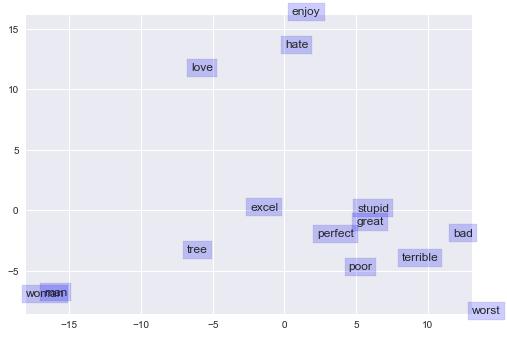

In [20]:
for i in xrange(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='blue', alpha=0.2))

plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

In [21]:
model.most_similar('awful')

[(u'atrocious', 0.837166428565979),
 (u'terrible', 0.8371261358261108),
 (u'horrible', 0.8249979019165039),
 (u'abysmal', 0.7943110466003418),
 (u'horrid', 0.773518443107605),
 (u'dreadful', 0.7683756351470947),
 (u'horrendous', 0.7505302429199219),
 (u'appalling', 0.7383407354354858),
 (u'lousy', 0.7208585739135742),
 (u'bad', 0.7033074498176575)]

In [22]:
word_vectors.syn0.shape

(19279L, 128L)

In [23]:
# step 1: Vector averaging

In [24]:
# Can add in the stop word here
def getAvgVec(words, word_vectors, vector_dims):
    # Function to average all of word vectors in a given paragraph
    #
    # Pre-initilize an empty numpy array
    avgVec = np.zeros((vector_dims,),dtype='float32')
    #
    nwords=0.
    #
    # Index2word is a list that contains the names of the words in the
    # models vocabulary.
    index2word_set = set(word_vectors.index2word)
    #
    # Loop over each word in the review and add corresponding word 
    # vectors if the word is in the vocabulary of the model.
    for word in words:
        if word in index2word_set:
            nwords += 1
            avgVec += word_vectors[word]
        
    avgVec /= nwords
    
    return avgVec


def getReviewFeatures(reviews, word_vectors, vector_dims):
    
    # Pre-initialize an empty 2D numpy array
    reviewVec = np.zeros((len(reviews),vector_dims),dtype='float32')
    # 
    count = 0
    
    d = len(reviews)/100
    
    for review in reviews:
        
        reviewVec[count] = getAvgVec(review, word_vectors, vector_dims)
        
        progress_update(count,d,len(reviews))
        
        count += 1
        
    
    return reviewVec

In [25]:
# Calculating the averaged feature vectors for train and test reviews

labeled_train_bow = data_dictionary['labeled_train_bow']
print "Creating averaged feature vectors for training set..."
clean_train_reviews = []
for review in labeled_train_bow:
    clean_train_reviews.append(doc2wordlist(review,stop_words=True))
trainVecs = getReviewFeatures(clean_train_reviews,word_vectors,vector_dims)
print     
test_bow = data_dictionary['test_bow']
print "Creating averaged feature vectors for testing set..."
clean_test_reviews = []
for review in test_bow:
    clean_test_reviews.append(doc2wordlist(review,stop_words=True))
testVecs = getReviewFeatures(clean_test_reviews,word_vectors,vector_dims)

Creating averaged feature vectors for training set...
100 percent has been processed...
Creating averaged feature vectors for testing set...


In [26]:
labeled_train_labels = data_dictionary['labeled_train_labels']
print "Training the random forest..."
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,oob_score=True,verbose=1)
clf.fit(trainVecs,labeled_train_labels)


Training the random forest...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
            verbose=1, warm_start=False)

In [27]:
test_data = pd.read_csv('./raw_data/testData.tsv',header=0,delimiter='\t',quoting=csv.QUOTE_NONE)
test_data.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [28]:
# Test & extract results 
result = clf.predict( testVecs )

# Write the test results 
output = pd.DataFrame( data={"id":test_data["id"], "sentiment":result} )
output.to_csv( "Word2Vec_AverageVectors.csv", index=False, quoting=3 )

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


(0, 4000)

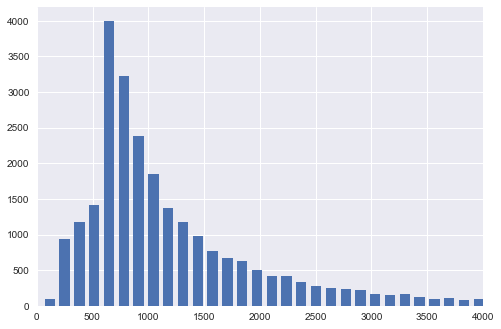

In [29]:
count = []
for review in labeled_train_bow:
    count.append(len(review))

plt.hist(count, bins=100,rwidth=0.7)
plt.xlim(0,4000)

In [30]:
# LSTM Embedding layer Keras

In [31]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras import callbacks

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

2018-01-08 02:43:28,549 : WARNING: The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


In [32]:
# Create index dictionary to convert words to indexes
index_dict = {}

for idx, word in enumerate(word_vectors.index2word):
    # Reserve 0 index to the masking
    index_dict[word] = idx+1
    
# Convert words to indexes representation for the dataset
sequences = []

for review in clean_train_reviews:
    
    temp =[]
    
    for word in review:
        # Convert and append for single file
        temp.append(index_dict.get(word,0))
    # Combine files in the dataset
    sequences.append(temp)
    
# Fixate input sequence length to 300; truncate sequences with more than 300 words and pad those with less. 

SEQUENCE_LENGTH = 300    

X_LSTM_train = pad_sequences(sequences,padding='post',truncating='post',maxlen=SEQUENCE_LENGTH)
y_LSTM_train = labeled_train_labels

In [37]:
test_sq = []

for review in clean_test_reviews:    
    temp = []   
    for word in review:
        temp.append(index_dict.get(word,0))
    test_sq.append(temp)

X_LSTM_test = pad_sequences(test_sq,padding='post',truncating='post',maxlen=SEQUENCE_LENGTH)

In [33]:
# Define embedding dimension and number of symbols
EMBEDDING_DIM = 128
n_symbols = len(index_dict)+1

# Generate embedding matrix
embedding_matrix = np.zeros((n_symbols,EMBEDDING_DIM),dtype='float32')
for word, idx in index_dict.items():
    embedding_matrix[idx,:] =  word_vectors[word]
    

In [34]:
# Define Keras embedding
embedding_layer = Embedding(n_symbols,EMBEDDING_DIM,weights=[embedding_matrix]\
                             ,input_length=SEQUENCE_LENGTH,trainable=False)
# Define input layer
sequence_input = Input(shape=(SEQUENCE_LENGTH,),dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

In [35]:
HIDDEN_LAYER_SIZE = 128
BATCH_SIZE = 32
NUM_EPOCHS = 5

x = LSTM(HIDDEN_LAYER_SIZE, input_shape=(SEQUENCE_LENGTH,EMBEDDING_DIM),\
         return_sequences=False,dropout=0.2,recurrent_dropout=0.2)(embedded_sequences)

preds = Dense(1,activation='sigmoid')(x)

LSTM_model = Model(sequence_input,preds)

LSTM_model.compile(loss='binary_crossentropy',optimizer='rmsprop',\
                   metrics=['accuracy'])

print LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 128)          2467840   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,599,553
Trainable params: 131,713
Non-trainable params: 2,467,840
_________________________________________________________________
None


In [36]:
print 'Training...'

fname = './LSMT_with_embedding'
filepath = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'

cbks = [callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True,period=1),
            callbacks.EarlyStopping(monitor='val_loss', patience=3)]

LSTM_model.fit(X_LSTM_train,y_LSTM_train,batch_size=BATCH_SIZE,epochs=NUM_EPOCHS)

Training...


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '212' (I am process '11592')
2018-01-08 02:43:55,262 : WARNING: Overriding existing lock by dead process '212' (I am process '11592')


Epoch 1/5
25000/25000 [==============================] - 31828s 1s/step - loss: 0.6165 - acc: 0.6662

In [41]:
results = LSTM_model.predict(X_LSTM_test,batch_size=BATCH_SIZE,verbose=1)

25000/25000 [==============================] - 1627s 65ms/step

In [46]:
ypred = np.where(results>=0.5,1,0)
# Write the test results 
output = pd.DataFrame( data={"id":test_data["id"], "sentiment":ypred.flatten()} )
output.to_csv( "LSTM.csv", index=False, quoting=3 )